In [ ]:
import pandas as pd
import numpy as np
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud



In [258]:
class DataLoader:
    def __init__(self, data_path):
        self.data_path = data_path
        self.df = None

    def load_data(self):
        self.df = pd.read_csv(self.data_path, encoding='latin1')
        # print(self.df.head())
        return self.df


In [260]:
# Call Dataloader with path defined
data_path = 'tweets.csv'

# Load and preprocess data
loader = DataLoader(data_path)
df = loader.load_data()
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [262]:
class DataPreprocessor:
    def __init__(self, df):
        self.df = df

    def preprocess(self):
        self.df.rename(columns={'tweet_text': 'tweet', 'emotion_in_tweet_is_directed_at': 'brand_product', 'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'}, inplace=True)
        dict_sent = {'No emotion toward brand or product': "No emotion", 'Positive emotion': 'Positive', 'Negative emotion': 'Negative', "I can't tell": 'Invalid'}
        self.df['sentiment'] = self.df['sentiment'].map(dict_sent)
        self.df['tweet'].dropna(inplace=True)
        self.df.drop_duplicates(inplace=True)
        self.df.drop(index=self.df[self.df['tweet'].isna()].index, inplace=True)
        self.fill_missing_brand_product()
        self.df.dropna(inplace=True)
        self.df = self.preprocess_text()
        return self.df

    def preprocess_text(self):
        self.df['cleaned_tweet'] = self.df['tweet'].apply(lambda x: re.sub(f'[{string.punctuation}]', '', x.lower()))
        self.df['user_name'] = self.df['cleaned_tweet'].apply(lambda x: x.split()[0] if x else '')
        self.df['cleaned_tweet'] = self.df['cleaned_tweet'].apply(lambda x: ' '.join(x.split()[1:]) if x else '')
        return self.df

    def fill_missing_brand_product(self):
        categories = np.array(['iPad', 'Apple', 'iPad', 'iPhone', 'Google', 'Android'])
        for i, row in self.df.iterrows():
            if pd.isnull(row['brand_product']):
                for category in np.concatenate((categories, np.char.lower(categories))):
                    if category in row['tweet']:
                        self.df.loc[i, 'brand_product'] = category
                        break

    def show_distribution(self):
        # Ensure there are no null values in 'brand_product' and 'sentiment' columns
        df_non_null = self.df.dropna(subset=['brand_product', 'sentiment'])

        # Distribution of Brand-Product
        brand_counts = df_non_null['brand_product'].value_counts()
        brand_counts = brand_counts.sort_values(ascending=True)

        plt.figure(figsize=(10, 6))
        colors = [
            'skyblue' if brand.lower() in [
                'ipad', 'apple', 'ipad or iphone app', 'iphone', 'other apple product or service'
            ] else 'limegreen' for brand in brand_counts.index
        ]

        plt.barh(brand_counts.index, brand_counts.values, color=colors)
        plt.xlabel('Count')
        plt.ylabel('Brand-Product')
        plt.title('Distribution of Brand-Product')
        plt.xticks(rotation=60)
        plt.tight_layout()
        plt.show()

        # Sentiment Counts by Brand
        plt.figure(figsize=(10, 6))
        sns.countplot(data=df_non_null, x='sentiment', hue='brand_product', palette='Set2')
        plt.title('Sentiment Counts by Brand')
        plt.xlabel('Sentiment')
        plt.ylabel('Count')
        plt.legend(title='Brand')
        plt.show()


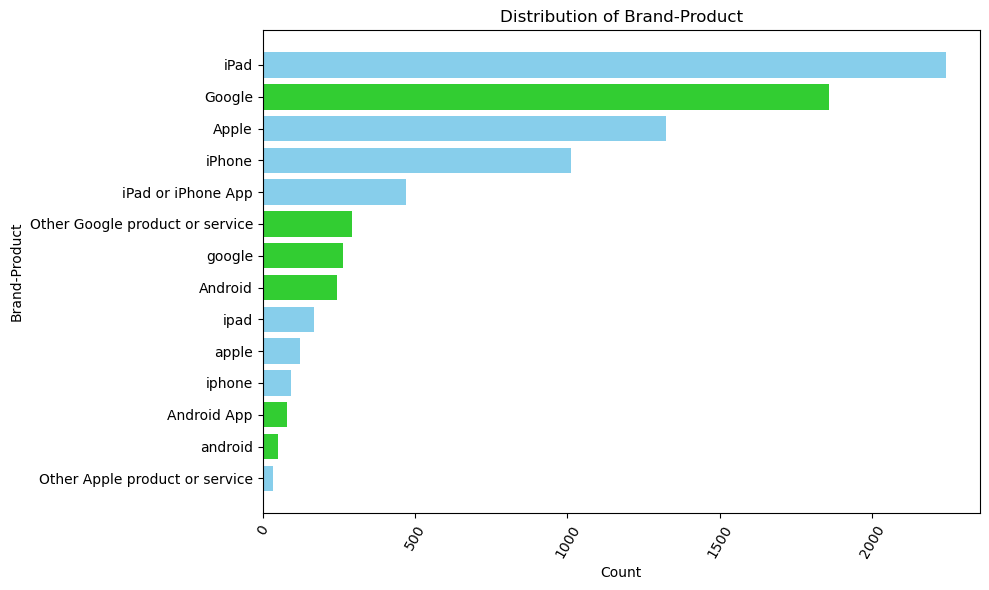

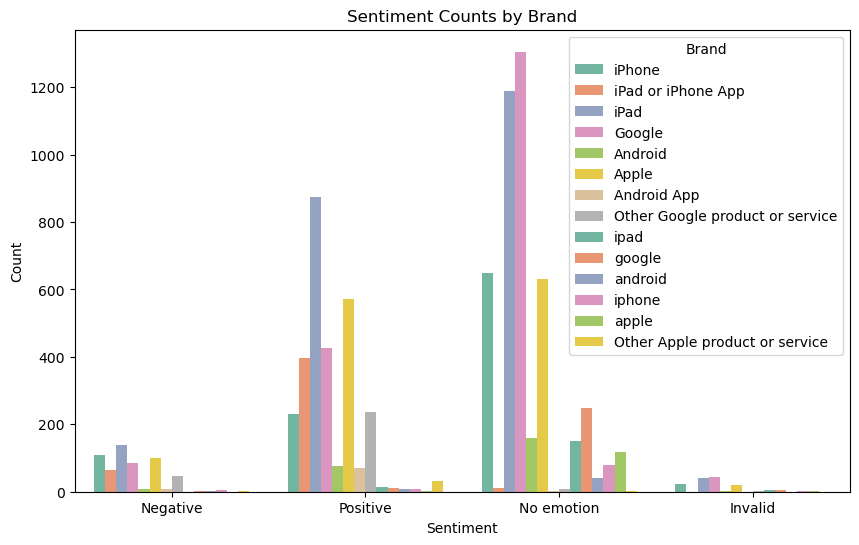

In [264]:
preprocessor = DataPreprocessor(df)
df = preprocessor.preprocess()
preprocessor.show_distribution()

In [266]:
class TextVectorizer:
    def __init__(self, df):
        self.df = df
        self.vectorizer = None
        self.X = None
        self.y = None

    def vectorize(self):
        self.vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
        self.X = self.vectorizer.fit_transform(self.df['cleaned_tweet'])
        self.y = self.df['sentiment']
        return train_test_split(self.X, self.y, test_size=0.2, random_state=42)

    def show_word_distribution(self):
        word_freq = self.vectorizer.get_feature_names_out()
        sum_words = self.X.sum(axis=0)
        word_freq = [(word, sum_words[0, idx]) for word, idx in self.vectorizer.vocabulary_.items()]
        word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)

        words = [wf[0] for wf in word_freq[:20]]
        counts = [wf[1] for wf in word_freq[:20]]

        plt.figure(figsize=(12, 6))
        sns.barplot(x=counts, y=words)
        plt.title('Top 20 Words by Frequency')
        plt.show()

    def show_wordcloud(self):
        all_tweets_text = ' '.join(self.df['cleaned_tweet'])

        wordcloud = WordCloud(background_color='white', max_words=200, max_font_size=40, scale=3, random_state=42)
        wordcloud.generate(all_tweets_text)

        plt.figure(figsize=(12, 8))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Word Cloud of Cleaned Tweets')
        plt.show()

C:\Users\jack\Documents\Flatiron\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


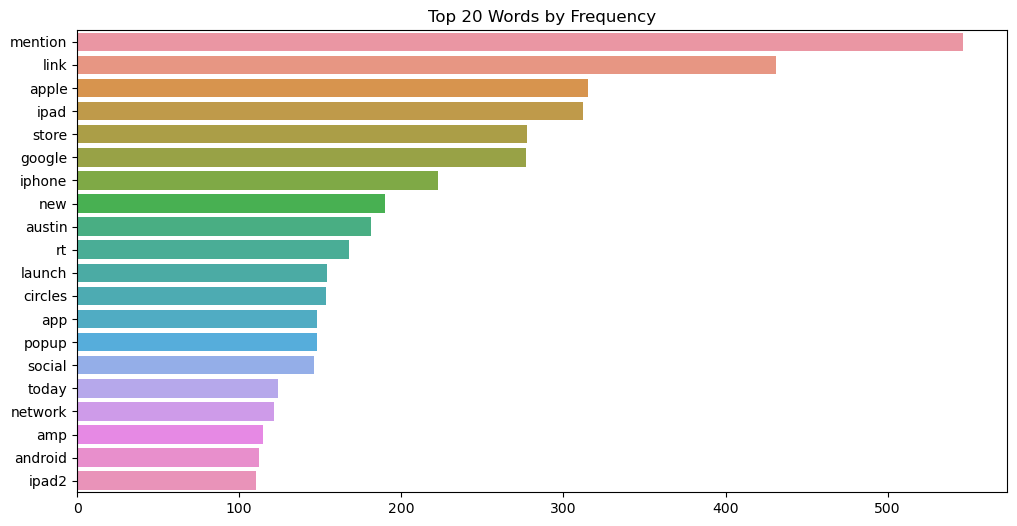

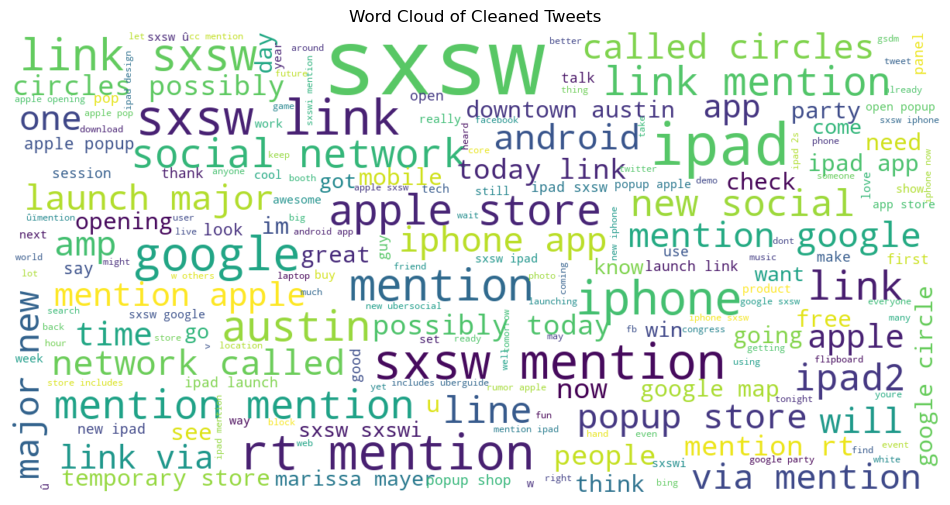

In [268]:
# Vectorize text and visualize
vectorizer = TextVectorizer(df)
X_train, X_test, y_train, y_test = vectorizer.vectorize()
vectorizer.show_word_distribution()
vectorizer.show_wordcloud()



In [270]:
class ModelTrainer:
    def __init__(self):
        self.models = {
            'Naive Bayes': MultinomialNB(),
            'SVC': LinearSVC(),
            'Logistic Regression': LogisticRegression(max_iter=1000),
            'Random Forest': RandomForestClassifier(n_estimators=100),
            'Gradient Boosting': GradientBoostingClassifier(n_estimators=100)
        }
        self.results = {}

    def train(self, X_train, y_train):
        for model_name, model in self.models.items():
            model.fit(X_train, y_train)
            self.results[model_name] = {'model': model}
        return self.results


In [272]:
# Train models
trainer = ModelTrainer()
results = trainer.train(X_train, y_train)

In [282]:
# ModelEvaluator class
class ModelEvaluator:
    def __init__(self, results):
        self.results = results

    def evaluate(self, X_test, y_test):
        for model_name, result in self.results.items():
            model = result['model']
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            self.results[model_name]['accuracy'] = accuracy
            if hasattr(model, "predict_proba"):
                y_prob = model.predict_proba(X_test)
                self.results[model_name]['y_prob'] = y_prob
            else:
                y_prob = model.decision_function(X_test)
                self.results[model_name]['y_prob'] = np.column_stack([1-y_prob, y_prob])
            self.results[model_name]['y_pred'] = y_pred
        return self.results

    def display_results(self):
        for model_name, result in self.results.items():
            print(f"{model_name} Accuracy: {result['accuracy']}")

    def plot_roc_curves(self, X_test, y_test):
        plt.figure(figsize=(10, 8))

        for model_name, result in self.results.items():
            model = result['model']
            y_prob = result['y_prob']

            fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1], pos_label='Positive')
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.legend(loc="lower right")
        plt.show()

Naive Bayes Accuracy: 0.62409200968523
SVC Accuracy: 0.6446731234866828
Logistic Regression Accuracy: 0.6476997578692494
Random Forest Accuracy: 0.6440677966101694
Gradient Boosting Accuracy: 0.6216707021791767


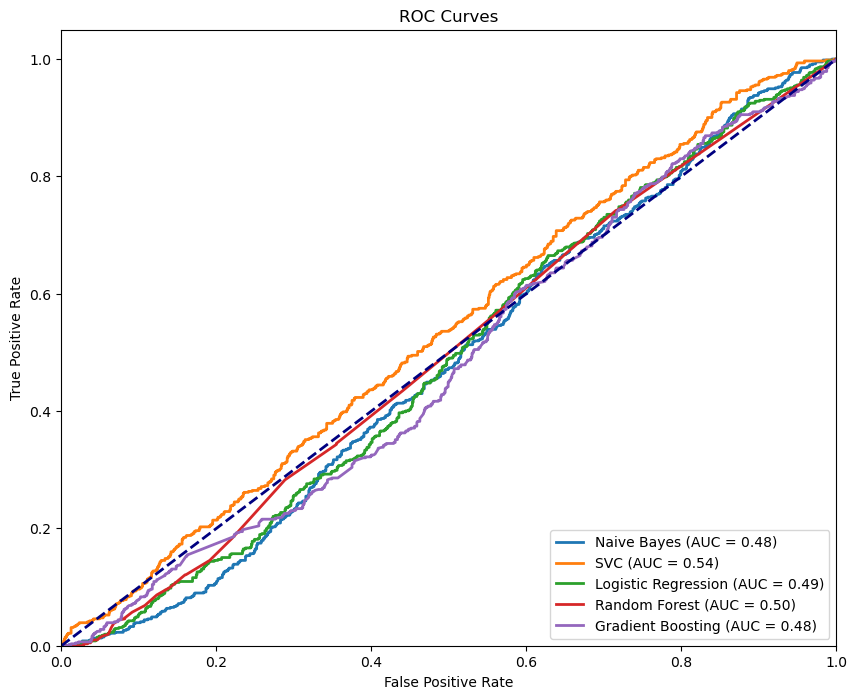

In [284]:
# Evaluate models and plot ROC curves
evaluator = ModelEvaluator(results)
evaluator.evaluate(X_test, y_test)
evaluator.display_results()
evaluator.plot_roc_curves(X_test, y_test)

In [302]:
class SentimentPredictor:
    def __init__(self, vectorizer, model):
        self.vectorizer = vectorizer
        self.model = model

    def predict_new_data(self, new_data_path):
        new_data = pd.read_csv(new_data_path)
        new_data_cleaned = new_data['tweet'].apply(lambda x: re.sub(f'[{string.punctuation}]', '', x.lower()))
        new_data_tfidf = self.vectorizer.transform(new_data_cleaned)
        new_data['predicted_sentiment'] = self.model.predict(new_data_tfidf)
        return new_data


In [306]:
# Predict new data with different models
# load data
new_data_path = 'sample_new_tweets.csv'

# Model selection
# Change the selected_model_name by any of the used models: Logistic Regression, Gradient Boosting, SVC, Random Forest, or Naive Bayes
selected_model_name = "SVC" 
selected_model = results[selected_model_name]['model']

predictor = SentimentPredictor(vectorizer.vectorizer, selected_model)
predicted_new_data = predictor.predict_new_data(new_data_path)
print(predicted_new_data)


                                               tweet predicted_sentiment
0          I love my new iPhone! It works perfectly.            Positive
1              My Google Pixel phone keeps crashing.            Negative
2        The battery life on my new iPad is amazing.            Positive
3          The Android OS is too complicated for me.          No emotion
4              Apple customer service is so helpful!            Positive
5  I am disappointed with the performance of my G...            Negative
6            This new iPhone update is really buggy.            Negative
7    The design of the new iPad is sleek and modern.            Positive
